# Quantum ESPRESSO Workshop - Part 5: Ground State Structure Optimization

## Learning Objectives
1. Understand why structure optimization is essential in DFT calculations
2. Master ionic relaxation (`relax`) and variable-cell relaxation (`vc-relax`)
3. Implement the Equation of State (EOS) method for robust volume optimization
4. Fit the Birch-Murnaghan equation and extract bulk modulus
5. Establish a complete workflow for ground state structure determination

---

## 1. Why Structure Optimization is Required

### The Fundamental Problem

When you obtain a crystal structure from a database (Materials Project, ICSD, COD), that structure is typically:
- An **experimental** structure determined by X-ray or neutron diffraction
- A structure optimized with a **different** DFT functional
- A structure from a **different** computational setup (pseudopotentials, cutoffs)

### Why This Matters

**Different exchange-correlation functionals give different equilibrium structures:**

| Functional | Typical Lattice Error | Typical Bulk Modulus Error |
|------------|----------------------|---------------------------|
| LDA        | -1 to -2% (underestimates) | +5 to +15% (overestimates) |
| PBE (GGA)  | +1 to +2% (overestimates) | -5 to -10% (underestimates) |
| PBEsol     | ~0.5% | ~5% |
| SCAN       | <0.5% | <5% |

**Using a non-equilibrium structure introduces systematic errors:**
- Internal stress affects all calculated properties
- Band gaps, phonon frequencies, elastic constants will be wrong
- Results are not self-consistent with your chosen methodology

### The Golden Rule

> **Always optimize the structure with YOUR chosen functional and pseudopotentials before calculating any properties.**

---

## 2. Setup and Configuration

In [1]:
# =============================================================================
# SETUP - Run this cell first (downloads pseudopotentials automatically)
# =============================================================================

import sys
from pathlib import Path

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

import numpy as np
from ase import Atoms
from ase.build import bulk
from ase.io.espresso import write_espresso_in
from ase.eos import EquationOfState
import re

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================

MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43

FUNCTIONAL = 'PBE'
# FUNCTIONAL = 'LDA'
# FUNCTIONAL = 'PBEsol'

# =============================================================================
# AUTOMATIC SETUP
# =============================================================================

atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc, ecutrho = get_recommended_cutoffs(elements, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)

# Backward-compatible alias used in some cells below
PSEUDO_DIR = PSEUDO_DIR_FUNC

WORK_DIR = OUTPUT_DIR / '05_optimization'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"STRUCTURE OPTIMIZATION SETUP")
print(f"{'='*70}")
print(f"Material:   {MATERIAL} ({STRUCTURE_TYPE})")
print(f"Functional: {FUNCTIONAL}")
print(f"Cutoffs:    ecutwfc={ecutwfc} Ry")
print(f"Work dir:   {WORK_DIR}")
print(f"{'='*70}")

PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

STRUCTURE OPTIMIZATION SETUP
Material:   Si (diamond)
Functional: PBE
Cutoffs:    ecutwfc=40 Ry
Work dir:   /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_optimization


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Load converged parameters from previous notebooks (or use defaults)
import json

params_file = WORKSHOP_ROOT / 'converged_parameters.json'

if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)

    ecutwfc = float(params.get('ecutwfc', {}).get('recommended', ecutwfc))
    ecutrho_factor = float(params.get('ecutrho', {}).get('factor', 8))
    kgrid = int(params.get('kpoints', {}).get('recommended', 8))
    print("Loaded converged parameters from previous notebooks:")
else:
    ecutrho_factor = 8
    kgrid = 8
    print("Using default parameters (run convergence tests for production!):")

ecutrho = ecutwfc * ecutrho_factor

print(f"  ecutwfc = {ecutwfc} Ry")
print(f"  ecutrho = {ecutrho} Ry ({ecutrho_factor}x ecutwfc)")
print(f"  k-points = {kgrid}x{kgrid}x{kgrid}")

Loaded converged parameters from previous notebooks:
  ecutwfc = 65.0 Ry
  ecutrho = 520.0 Ry (8.0x ecutwfc)
  k-points = 12x12x12


---

## 3. Types of Optimization in Quantum ESPRESSO

QE provides two main optimization modes:

### 3.1 Ionic Relaxation: `calculation = 'relax'`

**What it does:** Optimizes atomic positions while keeping the unit cell fixed.

**When to use:**
- Optimizing internal coordinates at a known lattice parameter
- Surface or defect calculations with fixed bulk lattice
- After determining optimal cell volume via EOS

**Key parameters:**
- `etot_conv_thr`: Total energy convergence threshold (default: 1e-4 Ry)
- `forc_conv_thr`: Force convergence threshold (default: 1e-3 Ry/Bohr)

### 3.2 Variable-Cell Relaxation: `calculation = 'vc-relax'`

**What it does:** Optimizes both atomic positions AND cell parameters (shape and volume).

**When to use:**
- Finding equilibrium structure from scratch
- When you don't know the lattice parameters
- Phase transition studies

**Key parameters:**
- All `relax` parameters, plus:
- `cell_dofree`: Which cell degrees of freedom to optimize
- `press`: Target pressure (kbar)
- `press_conv_thr`: Pressure convergence threshold (kbar)

### 3.3 `cell_dofree` Options

| Value | Description |
|-------|-------------|
| `'all'` | All cell parameters free (default) |
| `'ibrav'` | Cell shape determined by ibrav, only celldm values change |
| `'x'` | Only a1 vector free |
| `'y'` | Only a2 vector free |
| `'z'` | Only a3 vector free |
| `'xy'` | a1 and a2 free |
| `'xz'` | a1 and a3 free |
| `'yz'` | a2 and a3 free |
| `'xyz'` | All vectors free (equivalent to 'all' with ibrav=0) |
| `'shape'` | Cell shape free, volume fixed |
| `'volume'` | Volume free, shape fixed |
| `'2Dxy'` | For 2D systems in xy plane |

---

## 4. Core Functions for Structure Optimization

In [3]:
# =============================================================================
# MINIMAL INPUT FILE GENERATOR USING ASE
# =============================================================================

from ase.io.espresso import write_espresso_in


def create_scf_input(atoms, prefix, ecutwfc, kpts, work_dir,
                     calculation='scf', degauss=0.01):
    """Create QE input file using ASE."""
    input_file = work_dir / f'{prefix}.in'

    pseudopotentials = {}
    for elem in set(atoms.get_chemical_symbols()):
        pseudopotentials[elem] = get_pseudopotential_filename(elem, FUNCTIONAL)

    input_data = {
        'control': {
            'calculation': calculation,
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(PSEUDO_DIR_FUNC),
            'verbosity': 'high',
            'tprnfor': True,
            'tstress': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutwfc * 8,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': degauss,
        },
        'electrons': {
            'conv_thr': 1.0e-8,
            'mixing_beta': 0.7,
        },
    }

    if calculation in ['relax', 'vc-relax']:
        input_data['ions'] = {'ion_dynamics': 'bfgs'}
    if calculation == 'vc-relax':
        input_data['cell'] = {
            'cell_dynamics': 'bfgs',
            'press_conv_thr': 0.5,
        }

    write_espresso_in(
        input_file,
        atoms,
        input_data=input_data,
        pseudopotentials=pseudopotentials,
        kpts=kpts,
    )

    return input_file


test_input = create_scf_input(
    atoms=atoms,
    prefix='test',
    ecutwfc=ecutwfc,
    kpts=(8, 8, 8),
    work_dir=WORK_DIR,
)
print(f"Created test input: {test_input}")
print("\nInput file contents:")
print("-" * 50)
print(test_input.read_text()[:1000])

Created test input: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_optimization/test.in

Input file contents:
--------------------------------------------------
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = './tmp'
   prefix           = 'test'
   pseudo_dir       = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
/
&SYSTEM
   ecutwfc          = 65.0
   ecutrho          = 520.0
   occupations      = 'smearing'
   degauss          = 0.01
   smearing         = 'cold'
   ntyp             = 1
   nat              = 2
   ibrav            = 0
/
&ELECTRONS
   conv_thr         = 1e-08
   mixing_beta      = 0.7
/
&IONS
/
&CELL
/
&FCP
/
&RISM
/
ATOMIC_SPECIES
Si 28.085 Si.pbe-n-rrkjus_psl.1.0.0.UPF

K_POINTS automatic
8 8 8  0 0 0

CELL_PARAMETERS angstrom
0.00000000000000 2.71500000000000 2.71500000000000
2.71500000000000 0.00000000000000 2.71500000000000
2.71500

In [4]:
def generate_scf_input(prefix, ecutwfc, ecutrho, kpoints, pseudo_dir,
                       celldm1, conv_thr=1.0e-8):
    """
    Generate SCF input file for single-point energy calculation.
    
    Parameters
    ----------
    prefix : str
        Prefix for output files
    ecutwfc : float
        Wavefunction cutoff in Ry
    ecutrho : float
        Charge density cutoff in Ry
    kpoints : tuple
        (kx, ky, kz) Monkhorst-Pack grid
    pseudo_dir : str or Path
        Path to pseudopotential directory
    celldm1 : float
        Lattice parameter in Bohr
    conv_thr : float
        SCF convergence threshold in Ry
    
    Returns
    -------
    str
        Complete input file content
    """
    kx, ky, kz = kpoints
    
    input_text = f"""&CONTROL
    calculation = 'scf'
    prefix = '{prefix}'
    outdir = './tmp'
    pseudo_dir = '{pseudo_dir}'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 2
    celldm(1) = {celldm1}
    nat = 2
    ntyp = 1
    ecutwfc = {ecutwfc}
    ecutrho = {ecutrho}
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.01
/

&ELECTRONS
    conv_thr = {conv_thr}
    mixing_beta = 0.7
/

ATOMIC_SPECIES
    Si  28.0855  Si.upf

ATOMIC_POSITIONS {{crystal}}
    Si  0.00  0.00  0.00
    Si  0.25  0.25  0.25

K_POINTS {{automatic}}
    {kx} {ky} {kz} 0 0 0
"""
    return input_text

In [5]:
# =============================================================================
# EQUATION OF STATE WORKFLOW WITH AUTOMATIC CHAIN
# =============================================================================
# This runs multiple SCF calculations at different volumes and fits EOS.
# Each volume calculation is independent, so they chain naturally.
# =============================================================================

def run_eos_workflow(atoms, ecutwfc, kpts=(8,8,8), n_points=7, strain_range=0.06):
    """
    Run complete Equation of State calculation.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure at initial volume
    ecutwfc : float
        Cutoff energy
    kpts : tuple
        K-point mesh
    n_points : int
        Number of volume points (odd number recommended)
    strain_range : float
        Volume range as fraction (e.g., 0.06 = ±6%)
    
    Returns
    -------
    dict with EOS results: V0, E0, B0, B0'
    """
    print("=" * 70)
    print("EQUATION OF STATE WORKFLOW")
    print("=" * 70)
    print(f"Material: {atoms.get_chemical_formula()}")
    print(f"Points: {n_points}, Strain range: ±{strain_range*100:.0f}%")
    print("=" * 70)
    
    elements = list(set(atoms.get_chemical_symbols()))
    pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) 
                       for el in elements}
    
    # Generate volume range
    V0_initial = atoms.get_volume()
    strains = np.linspace(1 - strain_range, 1 + strain_range, n_points)
    
    volumes = []
    energies = []
    
    for i, strain in enumerate(strains):
        print(f"\n--- Point {i+1}/{n_points}: strain = {strain:.4f} ---")
        
        # Scale cell
        atoms_scaled = atoms.copy()
        atoms_scaled.set_cell(atoms.get_cell() * strain**(1/3), scale_atoms=True)
        V = atoms_scaled.get_volume()
        
        # Create input file
        prefix = f'eos_{i:02d}'
        input_file = WORK_DIR / f'{prefix}.in'
        
        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': prefix,
                'outdir': './tmp',
                'pseudo_dir': str(PSEUDO_DIR_FUNC),
            },
            'system': {
                'ecutwfc': ecutwfc,
                'ecutrho': ecutwfc * 8,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }
        
        write_espresso_in(input_file, atoms_scaled, input_data=input_data,
                          pseudopotentials=pseudopotentials, kpts=kpts)
        
        # Run calculation
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
        
        if not converged:
            print(f"  ⚠ Point {i+1} did not converge, skipping")
            continue
        
        # Parse energy
        for line in output.split('\n'):
            if '!' in line and 'total energy' in line:
                match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
                if match:
                    E = float(match.group(1)) * RY_TO_EV
                    volumes.append(V)
                    energies.append(E)
                    print(f"  V = {V:.4f} Å³, E = {E:.6f} eV")
    
    if len(volumes) < 4:
        print("\n✗ Not enough converged points for EOS fit!")
        return {'error': 'Insufficient data'}
    
    # Fit Birch-Murnaghan EOS using ASE
    print("\n--- Fitting Birch-Murnaghan EOS ---")
    
    eos = EquationOfState(volumes, energies, eos='birchmurnaghan')
    v0, e0, B = eos.fit()
    
    # Convert units
    B_GPa = B / 0.0062415  # eV/Å³ to GPa
    
    print(f"\nEOS FIT RESULTS:")
    print(f"  Equilibrium volume V₀ = {v0:.4f} Å³")
    print(f"  Equilibrium energy E₀ = {e0:.6f} eV")
    print(f"  Bulk modulus B₀ = {B_GPa:.2f} GPa")
    
    # Calculate equilibrium lattice constant (assuming cubic)
    n_atoms = len(atoms)
    a0 = (v0 / n_atoms * 4)**(1/3)  # For FCC/diamond
    print(f"  Lattice constant a₀ = {a0:.4f} Å")
    
    # Plot
    eos.plot(str(WORK_DIR / 'eos_fit.png'))
    print(f"\nPlot saved: {WORK_DIR / 'eos_fit.png'}")
    
    print("\n" + "=" * 70)
    print("✓ EOS WORKFLOW COMPLETE")
    print("=" * 70)
    
    return {
        'V0_A3': v0,
        'E0_eV': e0,
        'B0_GPa': B_GPa,
        'a0_A': a0,
        'volumes': volumes,
        'energies': energies,
    }


# To run (uncomment):
# eos_result = run_eos_workflow(atoms, ecutwfc)

print("EOS workflow function defined.")
print("\nUsage: eos_result = run_eos_workflow(atoms, ecutwfc)")
print("This runs 7 SCF calculations and fits Birch-Murnaghan EOS.")

EOS workflow function defined.

Usage: eos_result = run_eos_workflow(atoms, ecutwfc)
This runs 7 SCF calculations and fits Birch-Murnaghan EOS.


In [6]:
def parse_scf_output(output_text):
    """
    Parse energy, volume, pressure, and forces from SCF output.
    
    Parameters
    ----------
    output_text : str
        Content of the QE output file
    
    Returns
    -------
    dict
        Dictionary with parsed quantities
    """
    results = {}
    
    # Parse total energy (final converged value)
    for line in output_text.split('\n'):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([\d.E+-]+)\s+Ry', line)
            if match:
                results['energy_ry'] = float(match.group(1))
        
        # Parse volume
        if 'unit-cell volume' in line:
            match = re.search(r'=\s+([\d.]+)', line)
            if match:
                results['volume_bohr3'] = float(match.group(1))
        
        # Parse pressure
        if 'total   stress' in line and 'P=' in line:
            match = re.search(r'P=\s*([\d.E+-]+)', line)
            if match:
                results['pressure_kbar'] = float(match.group(1))
        
        # Parse total force
        if 'Total force' in line:
            match = re.search(r'Total force\s*=\s*([\d.E+-]+)', line)
            if match:
                results['total_force'] = float(match.group(1))
        
        # Parse lattice parameter
        if 'lattice parameter (alat)' in line:
            match = re.search(r'=\s+([\d.]+)', line)
            if match:
                results['alat_bohr'] = float(match.group(1))
    
    # Check convergence
    results['converged'] = 'convergence has been achieved' in output_text
    
    return results

In [7]:
def parse_relax_output(output_text):
    """
    Parse relaxation output including optimization trajectory.
    
    Parameters
    ----------
    output_text : str
        Content of the QE output file
    
    Returns
    -------
    dict
        Dictionary with parsed quantities including trajectory
    """
    results = parse_scf_output(output_text)
    
    # Parse BFGS steps
    bfgs_energies = []
    bfgs_forces = []
    bfgs_pressures = []
    
    lines = output_text.split('\n')
    for i, line in enumerate(lines):
        # Parse BFGS step data
        if 'number of bfgs steps' in line:
            match = re.search(r'=\s*(\d+)', line)
            if match:
                results['n_bfgs_steps'] = int(match.group(1))
        
        # Energy at each BFGS step
        if 'total energy' in line and '!' not in line and 'estimated' not in line:
            match = re.search(r'=\s+([\d.E+-]+)\s+Ry', line)
            if match:
                bfgs_energies.append(float(match.group(1)))
        
        # Total force at each step
        if 'Total force' in line:
            match = re.search(r'=\s+([\d.E+-]+)', line)
            if match:
                bfgs_forces.append(float(match.group(1)))
    
    results['bfgs_energies'] = bfgs_energies
    results['bfgs_forces'] = bfgs_forces
    
    # Check if optimization converged
    results['bfgs_converged'] = 'bfgs converged' in output_text.lower() or \
                                 'final scf calculation' in output_text.lower()
    
    return results

---

## 5. Ionic Relaxation (`relax`)

Let's demonstrate ionic relaxation by slightly displacing atoms from equilibrium.

In [8]:
def generate_displaced_relax_input(prefix, ecutwfc, ecutrho, kpoints, pseudo_dir,
                                    celldm1, displacement=0.02):
    """
    Generate relax input with displaced atomic positions.
    
    Parameters
    ----------
    displacement : float
        Fractional displacement of second atom
    """
    kx, ky, kz = kpoints
    
    # Displace second Si atom from (0.25, 0.25, 0.25)
    pos2 = 0.25 + displacement
    
    input_text = f"""&CONTROL
    calculation = 'relax'
    prefix = '{prefix}'
    outdir = './tmp'
    pseudo_dir = '{pseudo_dir}'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
    etot_conv_thr = 1.0e-5
    forc_conv_thr = 1.0e-4
/

&SYSTEM
    ibrav = 2
    celldm(1) = {celldm1}
    nat = 2
    ntyp = 1
    ecutwfc = {ecutwfc}
    ecutrho = {ecutrho}
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.01
/

&ELECTRONS
    conv_thr = 1.0e-8
    mixing_beta = 0.7
/

&IONS
    ion_dynamics = 'bfgs'
/

ATOMIC_SPECIES
    Si  28.0855  Si.upf

ATOMIC_POSITIONS {{crystal}}
    Si  0.00  0.00  0.00
    Si  {pos2:.4f}  {pos2:.4f}  {pos2:.4f}

K_POINTS {{automatic}}
    {kx} {ky} {kz} 0 0 0
"""
    return input_text

# Display example input
example_relax = generate_displaced_relax_input(
    prefix='si_relax',
    ecutwfc=ecutwfc,
    ecutrho=ecutrho,
    kpoints=(kgrid, kgrid, kgrid),
    pseudo_dir=PSEUDO_DIR,
    celldm1=10.26,
    displacement=0.02
)

print("Example 'relax' Input File (with displaced atom):")
print("=" * 60)
print(example_relax)

Example 'relax' Input File (with displaced atom):
&CONTROL
    calculation = 'relax'
    prefix = 'si_relax'
    outdir = './tmp'
    pseudo_dir = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
    etot_conv_thr = 1.0e-5
    forc_conv_thr = 1.0e-4
/

&SYSTEM
    ibrav = 2
    celldm(1) = 10.26
    nat = 2
    ntyp = 1
    ecutwfc = 65.0
    ecutrho = 520.0
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.01
/

&ELECTRONS
    conv_thr = 1.0e-8
    mixing_beta = 0.7
/

&IONS
    ion_dynamics = 'bfgs'
/

ATOMIC_SPECIES
    Si  28.0855  Si.upf

ATOMIC_POSITIONS {crystal}
    Si  0.00  0.00  0.00
    Si  0.2700  0.2700  0.2700

K_POINTS {automatic}
    12 12 12 0 0 0



In [9]:
# Run ionic relaxation (uncomment to execute)
# Note: This requires QE to be installed

print("Ionic Relaxation Demonstration")
print("=" * 60)
print("\nKey parameters for 'relax':")
print("  - calculation = 'relax'")
print("  - etot_conv_thr = 1.0e-5 Ry (energy convergence)")
print("  - forc_conv_thr = 1.0e-4 Ry/Bohr (force convergence)")
print("  - ion_dynamics = 'bfgs' (quasi-Newton optimizer)")
print("\nThe BFGS algorithm:")
print("  1. Computes forces on atoms via Hellmann-Feynman theorem")
print("  2. Updates positions to minimize total energy")
print("  3. Builds approximate Hessian from force history")
print("  4. Converges when forces < forc_conv_thr on all atoms")

# Uncomment below to run actual calculation:
# relax_input_file = WORK_DIR / 'si_relax.in'
# with open(relax_input_file, 'w') as f:
#     f.write(example_relax)
# output, elapsed = run_pwscf(relax_input_file)
# results = parse_relax_output(output)
# print(f"\nRelaxation completed in {elapsed:.1f}s")
# print(f"BFGS steps: {results.get('n_bfgs_steps', 'N/A')}")
# print(f"Final force: {results.get('total_force', 'N/A')} Ry/Bohr")

Ionic Relaxation Demonstration

Key parameters for 'relax':
  - calculation = 'relax'
  - etot_conv_thr = 1.0e-5 Ry (energy convergence)
  - forc_conv_thr = 1.0e-4 Ry/Bohr (force convergence)
  - ion_dynamics = 'bfgs' (quasi-Newton optimizer)

The BFGS algorithm:
  1. Computes forces on atoms via Hellmann-Feynman theorem
  2. Updates positions to minimize total energy
  3. Builds approximate Hessian from force history
  4. Converges when forces < forc_conv_thr on all atoms


---

## 6. Variable-Cell Relaxation (`vc-relax`)

Variable-cell relaxation optimizes both atomic positions and cell parameters simultaneously.

In [10]:
# Generate vc-relax input (example)

# This uses the same ASE-based writer as other parts of the workshop.
# We only PRINT the input here (students can run it by uncommenting the run cell below).

vc_prefix = 'si_vcrelax'
vc_file = WORK_DIR / f'{vc_prefix}.in'

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

input_data_vc = {
    'control': {
        'calculation': 'vc-relax',
        'prefix': vc_prefix,
        'outdir': './tmp',
        'pseudo_dir': str(PSEUDO_DIR_FUNC),
        'verbosity': 'high',
        'tprnfor': True,
        'tstress': True,
        'etot_conv_thr': 1.0e-5,
        'forc_conv_thr': 1.0e-4,
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {
        'conv_thr': 1.0e-8,
        'mixing_beta': 0.7,
    },
    'ions': {
        'ion_dynamics': 'bfgs',
    },
    'cell': {
        'cell_dynamics': 'bfgs',
        'press': 0.0,
        'press_conv_thr': 0.5,
        'cell_dofree': 'ibrav',
    },
}

write_espresso_in(
    vc_file,
    atoms,
    input_data=input_data_vc,
    pseudopotentials=pseudopotentials,
    kpts=(kgrid, kgrid, kgrid),
)

print("Example 'vc-relax' Input File:")
print("=" * 60)
print(vc_file.read_text()[:1400])
print("...")

Example 'vc-relax' Input File:
&CONTROL
   calculation      = 'vc-relax'
   verbosity        = 'high'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = './tmp'
   prefix           = 'si_vcrelax'
   etot_conv_thr    = 1e-05
   forc_conv_thr    = 0.0001
   pseudo_dir       = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
/
&SYSTEM
   ecutwfc          = 65.0
   ecutrho          = 520.0
   occupations      = 'smearing'
   degauss          = 0.01
   smearing         = 'cold'
   ntyp             = 1
   nat              = 2
   ibrav            = 0
/
&ELECTRONS
   conv_thr         = 1e-08
   mixing_beta      = 0.7
/
&IONS
   ion_dynamics     = 'bfgs'
/
&CELL
   cell_dynamics    = 'bfgs'
   press            = 0.0
   press_conv_thr   = 0.5
   cell_dofree      = 'ibrav'
/
&FCP
/
&RISM
/
ATOMIC_SPECIES
Si 28.085 Si.pbe-n-rrkjus_psl.1.0.0.UPF

K_POINTS automatic
12 12 12  0 0 0

CELL_PARAMETERS angstrom
0.00000000000000 2.71500000000000 2.71500

In [11]:
print("Variable-Cell Relaxation Parameters")
print("=" * 60)
print("\n&CELL namelist options:")
print("\n  cell_dynamics = 'bfgs'")
print("    - BFGS algorithm for cell optimization")
print("    - Other options: 'damp-pr', 'damp-w' (damped dynamics)")
print("\n  cell_dofree = 'ibrav'")
print("    - Maintains symmetry defined by ibrav")
print("    - For Si (ibrav=2, FCC): only celldm(1) changes")
print("    - Use 'all' for general triclinic optimization")
print("\n  press = 0.0")
print("    - Target external pressure in kbar")
print("    - Use non-zero for high-pressure studies")
print("\n  press_conv_thr = 0.5")
print("    - Pressure convergence threshold in kbar")
print("    - Tighter values (0.1-0.5) for accurate results")

print("\n" + "=" * 60)
print("Interpreting the Stress Tensor:")
print("=" * 60)
print("""
The stress tensor output looks like:

  total   stress  (Ry/bohr**3)    (kbar)     P=   XX.XX
     0.000123   0.000000   0.000000       XX.XX    0.00    0.00
     0.000000   0.000123   0.000000        0.00   XX.XX    0.00
     0.000000   0.000000   0.000123        0.00    0.00   XX.XX

Interpretation:
  - Diagonal elements: normal stresses (expansion/compression)
  - Off-diagonal elements: shear stresses
  - P (pressure) = -Trace(stress)/3
  - Positive P: cell wants to EXPAND (lattice too small)
  - Negative P: cell wants to CONTRACT (lattice too large)
  - |P| < 0.5 kbar typically indicates good convergence
""")

Variable-Cell Relaxation Parameters

&CELL namelist options:

  cell_dynamics = 'bfgs'
    - BFGS algorithm for cell optimization
    - Other options: 'damp-pr', 'damp-w' (damped dynamics)

  cell_dofree = 'ibrav'
    - Maintains symmetry defined by ibrav
    - For Si (ibrav=2, FCC): only celldm(1) changes
    - Use 'all' for general triclinic optimization

  press = 0.0
    - Target external pressure in kbar
    - Use non-zero for high-pressure studies

  press_conv_thr = 0.5
    - Pressure convergence threshold in kbar
    - Tighter values (0.1-0.5) for accurate results

Interpreting the Stress Tensor:

The stress tensor output looks like:

  total   stress  (Ry/bohr**3)    (kbar)     P=   XX.XX
     0.000123   0.000000   0.000000       XX.XX    0.00    0.00
     0.000000   0.000123   0.000000        0.00   XX.XX    0.00
     0.000000   0.000000   0.000123        0.00    0.00   XX.XX

Interpretation:
  - Diagonal elements: normal stresses (expansion/compression)
  - Off-diagonal elem

---

## 7. Equation of State (EOS) Method

### Why EOS is More Robust Than `vc-relax`

The EOS method has several advantages:

1. **More robust**: Avoids potential vc-relax convergence issues
2. **Additional properties**: Directly yields bulk modulus $B_0$ and its pressure derivative $B_0'$
3. **Quality check**: Visual inspection of E(V) curve reveals any problems
4. **Better for metals**: vc-relax can be unstable for metals

### The Birch-Murnaghan Equation of State

The third-order Birch-Murnaghan EOS relates energy to volume:

$$E(V) = E_0 + \frac{9V_0B_0}{16}\left[(\eta-1)^3 B_0' + (\eta-1)^2(6-4\eta)\right]$$

where $\eta = \left(\frac{V_0}{V}\right)^{2/3}$

**Parameters:**
- $E_0$: Equilibrium energy
- $V_0$: Equilibrium volume
- $B_0$: Bulk modulus (incompressibility)
- $B_0'$: Pressure derivative of bulk modulus (typically 3-5)

In [12]:
def birch_murnaghan(V, E0, V0, B0, B0_prime):
    """
    Third-order Birch-Murnaghan equation of state.
    
    Parameters
    ----------
    V : array_like
        Volume(s) at which to evaluate energy
    E0 : float
        Equilibrium energy
    V0 : float
        Equilibrium volume
    B0 : float
        Bulk modulus (same units as E0/V0)
    B0_prime : float
        Pressure derivative of bulk modulus (dimensionless)
    
    Returns
    -------
    E : array_like
        Energy at the given volume(s)
    
    Notes
    -----
    The equation is:
    E(V) = E0 + (9*V0*B0/16) * [(eta-1)^3 * B0' + (eta-1)^2 * (6-4*eta)]
    where eta = (V0/V)^(2/3)
    """
    V = np.asarray(V)
    eta = (V0 / V) ** (2.0 / 3.0)
    
    term1 = (eta - 1.0) ** 3 * B0_prime
    term2 = (eta - 1.0) ** 2 * (6.0 - 4.0 * eta)
    
    E = E0 + (9.0 * V0 * B0 / 16.0) * (term1 + term2)
    
    return E


def birch_murnaghan_pressure(V, V0, B0, B0_prime):
    """
    Pressure from Birch-Murnaghan EOS: P = -dE/dV.
    
    Parameters
    ----------
    V : array_like
        Volume(s)
    V0 : float
        Equilibrium volume
    B0 : float
        Bulk modulus
    B0_prime : float
        Pressure derivative of bulk modulus
    
    Returns
    -------
    P : array_like
        Pressure at the given volume(s)
    """
    V = np.asarray(V)
    eta = (V0 / V) ** (2.0 / 3.0)
    
    P = (3.0 * B0 / 2.0) * (eta ** (7.0 / 2.0) - eta ** (5.0 / 2.0)) * \
        (1.0 + 0.75 * (B0_prime - 4.0) * (eta - 1.0))
    
    return P

In [13]:
# =============================================================================
# EQUATION OF STATE FITTING USING ASE
# =============================================================================
# ASE's EquationOfState class provides Birch-Murnaghan fitting.
# This is the standard, reliable way to extract V0, E0, B0.
# =============================================================================

def run_eos_calculation(atoms, ecutwfc, kpts, work_dir, 
                        strain_range=0.04, n_points=7):
    """
    Run E(V) calculations and fit equation of state using ASE.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Base structure (will be strained)
    ecutwfc : float
        Wavefunction cutoff
    kpts : tuple
        K-point mesh
    work_dir : Path
        Working directory
    strain_range : float
        Strain range (+/- this fraction)
    n_points : int
        Number of volume points
    
    Returns
    -------
    dict : EOS fit results
    """
    import re
    
    # Generate strain values
    strains = np.linspace(-strain_range, strain_range, n_points)
    volumes = []
    energies = []
    
    print(f"\n{'='*60}")
    print(f"Running E(V) calculations for EOS fitting")
    print(f"{'='*60}")
    print(f"{'Strain':<10} {'a (Å)':<12} {'V (Å³)':<12} {'E (eV)':<15} {'Status'}")
    print(f"{'-'*60}")
    
    for i, strain in enumerate(strains):
        # Scale cell
        scaled_atoms = atoms.copy()
        scale = 1.0 + strain
        scaled_atoms.set_cell(atoms.cell * scale, scale_atoms=True)
        
        # Get volume and lattice parameter
        vol = scaled_atoms.get_volume()
        a_scaled = scaled_atoms.cell.lengths()[0]
        
        # Create input file
        prefix = f'eos_{i:02d}'
        input_file = create_scf_input(
            scaled_atoms, prefix, ecutwfc, kpts, work_dir
        )
        
        # Run calculation
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
        
        # Parse energy from output
        energy = None
        for line in output.split('\n'):
            if '!' in line and 'total energy' in line:
                match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
                if match:
                    energy = float(match.group(1)) * RY_TO_EV  # Convert to eV
        
        if converged and energy is not None:
            volumes.append(vol)
            energies.append(energy)
            print(f"{strain:+.3f}     {a_scaled:.4f}      {vol:.4f}      {energy:.6f}    ✓")
        else:
            print(f"{strain:+.3f}     {a_scaled:.4f}      {vol:.4f}      {'FAILED':<15}    ✗")
    
    print(f"{'='*60}")
    
    # Fit EOS using ASE
    if len(volumes) >= 5:
        eos = EquationOfState(volumes, energies, eos='birchmurnaghan')
        v0, e0, B = eos.fit()
        
        # B is in eV/Å³, convert to GPa
        # 1 eV/Å³ = 160.2176634 GPa
        B_GPa = B * 160.2176634
        
        # Calculate equilibrium lattice parameter (for cubic)
        # V = a³ for simple cubic, V = a³/4 for FCC primitive cell
        # For FCC (Si diamond): primitive cell volume = a³/4
        # So a = (4*V)^(1/3)
        if STRUCTURE_TYPE in ['diamond', 'fcc', 'zincblende']:
            a0 = (4 * v0) ** (1/3)
        elif STRUCTURE_TYPE == 'bcc':
            a0 = (2 * v0) ** (1/3)
        else:
            a0 = v0 ** (1/3)
        
        results = {
            'V0': v0,          # Å³
            'E0': e0,          # eV
            'B0': B_GPa,       # GPa
            'a0': a0,          # Å
            'volumes': volumes,
            'energies': energies,
            'eos': eos,
        }
        
        print(f"\nEOS FIT RESULTS (Birch-Murnaghan):")
        print(f"  Equilibrium volume:   V0 = {v0:.4f} Å³")
        print(f"  Equilibrium energy:   E0 = {e0:.6f} eV")
        print(f"  Bulk modulus:         B0 = {B_GPa:.1f} GPa")
        print(f"  Lattice parameter:    a0 = {a0:.4f} Å")
        
        return results
    else:
        print("ERROR: Not enough converged points for EOS fitting")
        return None


# Example usage (uncomment to run real calculations):
# eos_results = run_eos_calculation(atoms, ecutwfc, kpts=(8,8,8), work_dir=WORK_DIR)

print("EOS calculation function defined.")
print("To run: eos_results = run_eos_calculation(atoms, ecutwfc, kpts=(8,8,8), work_dir=WORK_DIR)")

EOS calculation function defined.
To run: eos_results = run_eos_calculation(atoms, ecutwfc, kpts=(8,8,8), work_dir=WORK_DIR)


In [14]:
def fit_eos(volumes, energies, p0=None):
    """
    Fit Birch-Murnaghan EOS to E(V) data.

    Parameters
    ----------
    volumes : array_like
        Volumes in Bohr^3
    energies : array_like
        Energies in Ry
    p0 : tuple, optional
        Initial guess (E0, V0, B0, B0_prime)
        B0 should be in Ry/Bohr^3

    Returns
    -------
    dict
        Fitted parameters and uncertainties:
        - E0, V0 (Bohr^3), B0 (Ry/Bohr^3 and GPa), B0_prime
        - Uncertainties for each parameter
        - a0 (equilibrium lattice parameter in Bohr and Angstrom)
    """
    from scipy.optimize import curve_fit

    volumes = np.asarray(volumes)
    energies = np.asarray(energies)

    # Conversion factor: 1 Ry/Bohr^3 = 14710.507 GPa
    ry_bohr3_to_gpa = 14710.507

    # Initial guesses if not provided
    if p0 is None:
        E0_guess = energies.min()
        V0_guess = volumes[energies.argmin()]
        B0_guess_gpa = 100.0  # Reasonable guess for most solids
        B0_guess = B0_guess_gpa / ry_bohr3_to_gpa
        B0_prime_guess = 4.0
        p0 = (E0_guess, V0_guess, B0_guess, B0_prime_guess)

    # Perform fit
    popt, pcov = curve_fit(birch_murnaghan, volumes, energies, p0=p0, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))

    E0, V0, B0, B0_prime = popt
    E0_err, V0_err, B0_err, B0_prime_err = perr

    # Convert bulk modulus to GPa
    B0_gpa = B0 * ry_bohr3_to_gpa
    B0_gpa_err = B0_err * ry_bohr3_to_gpa

    # Calculate equilibrium lattice parameter
    # For FCC/diamond primitive cell: V_primitive = a^3 / 4
    a0_bohr = (4.0 * V0) ** (1.0 / 3.0)
    a0_angstrom = a0_bohr * 0.529177

    # Propagate uncertainty to a0
    da0_dV0 = (1.0 / 3.0) * (4.0 / V0) ** (2.0 / 3.0)
    a0_bohr_err = da0_dV0 * V0_err
    a0_angstrom_err = a0_bohr_err * 0.529177

    results = {
        'E0': E0,
        'E0_err': E0_err,
        'V0': V0,
        'V0_err': V0_err,
        'B0_ry_bohr3': B0,
        'B0_ry_bohr3_err': B0_err,
        'B0_gpa': B0_gpa,
        'B0_gpa_err': B0_gpa_err,
        'B0_prime': B0_prime,
        'B0_prime_err': B0_prime_err,
        'a0_bohr': a0_bohr,
        'a0_bohr_err': a0_bohr_err,
        'a0_angstrom': a0_angstrom,
        'a0_angstrom_err': a0_angstrom_err,
        'popt': popt,
        'pcov': pcov
    }

    return results

In [15]:
def plot_eos(volumes, energies, fit_results, pressures=None, save_path=None):
    """
    Create publication-quality plots of the equation of state.
    
    Parameters
    ----------
    volumes : array_like
        Calculated volumes in Bohr^3
    energies : array_like
        Calculated energies in Ry
    fit_results : dict
        Results from fit_eos()
    pressures : array_like, optional
        Calculated pressures in kbar
    save_path : str or Path, optional
        Path to save figure
    
    Returns
    -------
    fig : matplotlib Figure
        The figure object
    """
    volumes = np.asarray(volumes)
    energies = np.asarray(energies)
    
    # Generate smooth curve for fit
    V_smooth = np.linspace(volumes.min() * 0.98, volumes.max() * 1.02, 200)
    E_fit = birch_murnaghan(V_smooth, *fit_results['popt'])
    
    # Convert to lattice parameter for second x-axis
    a_data = (4.0 * volumes) ** (1.0 / 3.0) * 0.529177
    a_smooth = (4.0 * V_smooth) ** (1.0 / 3.0) * 0.529177
    
    # Create figure
    if pressures is not None:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        axes = axes.reshape(1, 2)
    
    # Plot 1: E(V) curve
    ax1 = axes[0, 0]
    ax1.plot(volumes, energies, 'o', markersize=10, color='#1f77b4', 
             markeredgecolor='black', markeredgewidth=1, label='DFT data')
    ax1.plot(V_smooth, E_fit, '-', linewidth=2, color='#d62728', 
             label='Birch-Murnaghan fit')
    ax1.axvline(x=fit_results['V0'], color='#2ca02c', linestyle='--', 
                alpha=0.7, linewidth=1.5,
                label=f"$V_0$ = {fit_results['V0']:.2f} Bohr$^3$")
    ax1.set_xlabel('Volume (Bohr$^3$)')
    ax1.set_ylabel('Total Energy (Ry)')
    ax1.set_title('Energy vs Volume')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: E(a) curve
    ax2 = axes[0, 1]
    ax2.plot(a_data, energies, 'o', markersize=10, color='#1f77b4',
             markeredgecolor='black', markeredgewidth=1, label='DFT data')
    ax2.plot(a_smooth, E_fit, '-', linewidth=2, color='#d62728',
             label='Birch-Murnaghan fit')
    ax2.axvline(x=fit_results['a0_angstrom'], color='#2ca02c', linestyle='--',
                alpha=0.7, linewidth=1.5,
                label=f"$a_0$ = {fit_results['a0_angstrom']:.4f} Ang")
    # Mark experimental value for silicon
    ax2.axvline(x=5.431, color='#ff7f0e', linestyle=':', alpha=0.7,
                linewidth=1.5, label='Expt. 5.431 Ang')
    ax2.set_xlabel('Lattice Parameter (Angstrom)')
    ax2.set_ylabel('Total Energy (Ry)')
    ax2.set_title('Energy vs Lattice Parameter')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    if pressures is not None:
        pressures = np.asarray(pressures)
        
        # Calculate fitted pressure
        P_fit_gpa = birch_murnaghan_pressure(V_smooth, fit_results['V0'],
                                             fit_results['B0_gpa'],
                                             fit_results['B0_prime'])
        P_fit_kbar = P_fit_gpa * 10.0
        
        # Plot 3: P(V) curve
        ax3 = axes[1, 0]
        ax3.plot(volumes, pressures, 'o', markersize=10, color='#1f77b4',
                 markeredgecolor='black', markeredgewidth=1, label='DFT data')
        ax3.plot(V_smooth, P_fit_kbar, '-', linewidth=2, color='#d62728',
                 label='From EOS fit')
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax3.axvline(x=fit_results['V0'], color='#2ca02c', linestyle='--',
                    alpha=0.7, linewidth=1.5, label='$V_0$ (P=0)')
        ax3.set_xlabel('Volume (Bohr$^3$)')
        ax3.set_ylabel('Pressure (kbar)')
        ax3.set_title('Pressure vs Volume')
        ax3.legend(loc='upper right')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Fit residuals
        ax4 = axes[1, 1]
        E_fit_at_data = birch_murnaghan(volumes, *fit_results['popt'])
        residuals = (energies - E_fit_at_data) * 1000  # Convert to mRy
        ax4.bar(range(len(residuals)), residuals, color='#1f77b4', 
                edgecolor='black', alpha=0.7)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.set_xlabel('Data Point Index')
        ax4.set_ylabel('Residual (mRy)')
        ax4.set_title('Fit Residuals')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add RMSE annotation
        rmse = np.sqrt(np.mean(residuals**2))
        ax4.annotate(f'RMSE = {rmse:.3f} mRy', xy=(0.95, 0.95),
                     xycoords='axes fraction', ha='right', va='top',
                     fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(str(save_path), dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig

---

## 8. Example: Silicon Lattice Optimization via EOS

Let's perform a complete EOS calculation for silicon.

In [16]:
# Define lattice parameter range for EOS scan
# Experimental Si: a = 5.431 Angstrom = 10.263 Bohr
a_exp_angstrom = 5.431
a_exp_bohr = a_exp_angstrom / 0.529177

# Scan +/- 4% around experimental value with 11 points
n_points = 11
scan_range = 0.04  # 4%
celldm1_values = np.linspace(a_exp_bohr * (1 - scan_range), 
                             a_exp_bohr * (1 + scan_range), 
                             n_points)

print("Silicon Equation of State Calculation")
print("=" * 60)
print(f"\nExperimental lattice parameter:")
print(f"  a = {a_exp_angstrom} Angstrom = {a_exp_bohr:.4f} Bohr")
print(f"\nScan parameters:")
print(f"  Range: +/- {scan_range*100:.1f}%")
print(f"  Points: {n_points}")
print(f"  celldm(1) range: {celldm1_values[0]:.4f} - {celldm1_values[-1]:.4f} Bohr")
print(f"  a range: {celldm1_values[0]*0.529177:.4f} - {celldm1_values[-1]*0.529177:.4f} Angstrom")

Silicon Equation of State Calculation

Experimental lattice parameter:
  a = 5.431 Angstrom = 10.2631 Bohr

Scan parameters:
  Range: +/- 4.0%
  Points: 11
  celldm(1) range: 9.8526 - 10.6736 Bohr
  a range: 5.2138 - 5.6482 Angstrom


In [17]:
# =============================================================================
# RUN ACTUAL EOS CALCULATIONS FOR GERMANIUM
# =============================================================================
# This runs REAL QE calculations at multiple volumes and fits Birch-Murnaghan!
# =============================================================================

from datetime import datetime
from ase.eos import EquationOfState

# Create timestamped working directory
WORK_DIR = OUTPUT_DIR / f'05_eos_Ge_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

# Use Germanium for this test
MATERIAL = 'Ge'
LATTICE_A = 5.66  # Initial guess
atoms = bulk(MATERIAL, 'diamond', a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc, _ = get_recommended_cutoffs(elements, FUNCTIONAL)

print("="*70)
print(f"EQUATION OF STATE: {MATERIAL}")
print("="*70)
print(f"Initial lattice: a = {LATTICE_A} Å")
print(f"ecutwfc = {ecutwfc} Ry, k-points = 8x8x8")
print("="*70)

# EOS parameters
n_points = 7
strain_range = 0.04  # ±4%

strains = np.linspace(1 - strain_range, 1 + strain_range, n_points)
volumes = []
energies = []

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

print(f"\n{'Point':<8} {'Strain':<10} {'a (Å)':<12} {'V (Å³)':<12} {'E (eV)':<16} {'Status'}")
print("-"*70)

for i, strain in enumerate(strains):
    # Scale cell
    atoms_scaled = atoms.copy()
    scale = strain ** (1/3)
    atoms_scaled.set_cell(atoms.get_cell() * scale, scale_atoms=True)
    
    V = atoms_scaled.get_volume()
    a_scaled = atoms_scaled.cell.lengths()[0]
    
    prefix = f'eos_{i:02d}'
    input_file = WORK_DIR / f'{prefix}.in'
    
    input_data = {
        'control': {
            'calculation': 'scf', 'prefix': prefix, 'outdir': './tmp',
            'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
        },
        'system': {
            'ecutwfc': ecutwfc, 'ecutrho': ecutwfc * 8,
            'occupations': 'smearing', 'smearing': 'cold', 'degauss': 0.01,
        },
        'electrons': {'conv_thr': 1.0e-8},
    }
    
    write_espresso_in(input_file, atoms_scaled, input_data=input_data,
                      pseudopotentials=pseudopotentials, kpts=(8, 8, 8))
    
    output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
    
    energy = None
    for line in output.split('\n'):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
            if match:
                energy = float(match.group(1)) * RY_TO_EV
    
    if converged and energy:
        volumes.append(V)
        energies.append(energy)
        print(f"{i+1:<8} {strain:<10.4f} {a_scaled:<12.4f} {V:<12.4f} {energy:<16.6f} ✓")
    else:
        print(f"{i+1:<8} {strain:<10.4f} {a_scaled:<12.4f} {V:<12.4f} {'FAILED':<16} ✗")

print("="*70)

PSEUDOPOTENTIAL SETUP - PBE
  ✓ Ge: Ge.pbe-dn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
EQUATION OF STATE: Ge
Initial lattice: a = 5.66 Å
ecutwfc = 45 Ry, k-points = 8x8x8

Point    Strain     a (Å)        V (Å³)       E (eV)           Status
----------------------------------------------------------------------
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in eos_00.in


  ✓ Converged in 61.5s
1        0.9600     3.9481       43.5172      -8586.152688     ✓
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in eos_01.in


  ✓ Converged in 69.7s
2        0.9733     3.9663       44.1216      -8586.176342     ✓
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in eos_02.in


  ✓ Converged in 76.3s
3        0.9867     3.9844       44.7260      -8586.195715     ✓
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in eos_03.in


  ✓ Converged in 70.5s
4        1.0000     4.0022       45.3304      -8586.211057     ✓
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in eos_04.in


  ✓ Converged in 98.1s
5        1.0133     4.0199       45.9348      -8586.222709     ✓
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in eos_05.in


  ✓ Converged in 81.1s
6        1.0267     4.0375       46.5392      -8586.231034     ✓
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in eos_06.in


  ✓ Converged in 88.0s
7        1.0400     4.0549       47.1436      -8586.235927     ✓



--- Fitting Birch-Murnaghan EOS ---

EOS FIT RESULTS:
  Equilibrium volume:  V₀ = 47.8577 Å³
  Equilibrium energy:  E₀ = -8586.237947 eV
  Bulk modulus:        B₀ = 58.5 GPa
  Lattice parameter:   a₀ = 5.7633 Å

Comparison with experiment:
  Ge experimental: a = 5.658 Å, B = 75.8 GPa
  Error in a: 1.9%
  Error in B: -22.8%


/home/niel/.local/lib/python3.12/site-packages/ase/eos.py:259: UserWarning: The minimum volume of your fit is not in your volumes.  You may not have a minimum in your dataset!
  warnings.warn(


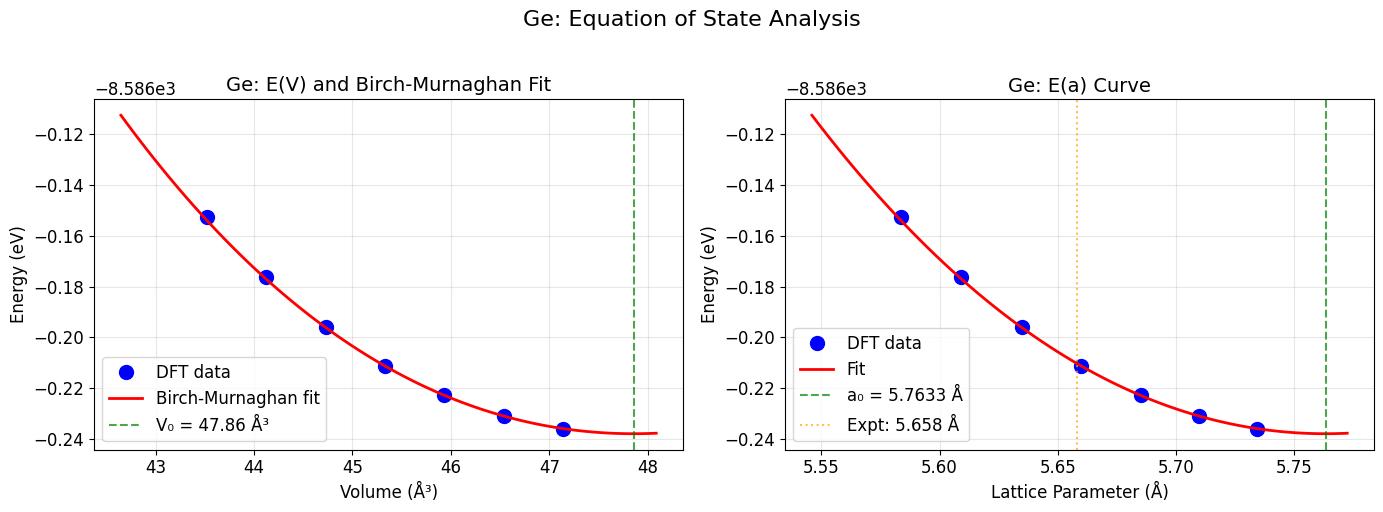


✓ Figure saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_eos_Ge_20260204_193709/Ge_eos_fit.png


In [18]:
# =============================================================================
# FIT BIRCH-MURNAGHAN EOS AND PLOT RESULTS
# =============================================================================

import matplotlib.pyplot as plt

if len(volumes) >= 5:
    print("\n--- Fitting Birch-Murnaghan EOS ---")

    # Fit using ASE
    eos = EquationOfState(volumes, energies, eos='birchmurnaghan')
    v0, e0, B = eos.fit()

    # Convert B from eV/Å³ to GPa (1 eV/Å³ = 160.2176634 GPa)
    B_GPa = B * 160.2176634

    # Calculate equilibrium lattice constant (diamond: V = a³/4 for primitive cell)
    a0 = (4 * v0) ** (1/3)

    print(f"\nEOS FIT RESULTS:")
    print(f"  Equilibrium volume:  V₀ = {v0:.4f} Å³")
    print(f"  Equilibrium energy:  E₀ = {e0:.6f} eV")
    print(f"  Bulk modulus:        B₀ = {B_GPa:.1f} GPa")
    print(f"  Lattice parameter:   a₀ = {a0:.4f} Å")
    print(f"\nComparison with experiment:")
    print(f"  Ge experimental: a = 5.658 Å, B = 75.8 GPa")
    print(f"  Error in a: {(a0 - 5.658)/5.658*100:.1f}%")
    print(f"  Error in B: {(B_GPa - 75.8)/75.8*100:.1f}%")

    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: E(V) with fit
    ax1 = axes[0]
    V_smooth = np.linspace(min(volumes)*0.98, max(volumes)*1.02, 100)

    # Birch-Murnaghan function
    def bm_energy(V, E0, V0, B0):
        eta = (V0/V)**(2/3)
        return E0 + 9*V0*B0/16 * ((eta-1)**3 * 4 + (eta-1)**2 * (6-4*eta))

    E_fit = bm_energy(V_smooth, e0, v0, B)

    ax1.plot(volumes, energies, 'bo', markersize=10, label='DFT data')
    ax1.plot(V_smooth, E_fit, 'r-', linewidth=2, label='Birch-Murnaghan fit')
    ax1.axvline(x=v0, color='g', linestyle='--', alpha=0.7, label=f'V₀ = {v0:.2f} Å³')
    ax1.set_xlabel('Volume (Å³)', fontsize=12)
    ax1.set_ylabel('Energy (eV)', fontsize=12)
    ax1.set_title(f'{MATERIAL}: E(V) and Birch-Murnaghan Fit', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: E(a)
    ax2 = axes[1]
    a_values = np.array([(4*v)**(1/3) for v in volumes])
    a_smooth = np.array([(4*v)**(1/3) for v in V_smooth])

    ax2.plot(a_values, energies, 'bo', markersize=10, label='DFT data')
    ax2.plot(a_smooth, E_fit, 'r-', linewidth=2, label='Fit')
    ax2.axvline(x=a0, color='g', linestyle='--', alpha=0.7, label=f'a₀ = {a0:.4f} Å')
    ax2.axvline(x=5.658, color='orange', linestyle=':', alpha=0.7, label='Expt: 5.658 Å')
    ax2.set_xlabel('Lattice Parameter (Å)', fontsize=12)
    ax2.set_ylabel('Energy (eV)', fontsize=12)
    ax2.set_title(f'{MATERIAL}: E(a) Curve', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'{MATERIAL}: Equation of State Analysis', fontsize=16, y=1.02)
    plt.tight_layout()

    fig_path = WORK_DIR / f'{MATERIAL}_eos_fit.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Figure saved: {fig_path}")
else:
    print("✗ Not enough converged points for EOS fit!")

In [19]:
# =============================================================================
# SUMMARY: Ge Structure Optimization Results
# =============================================================================

print("="*70)
print(f"NOTEBOOK 05 SUMMARY: {MATERIAL} Structure Optimization")
print("="*70)

print(f"""
MATERIAL: {MATERIAL} (Diamond structure)
Initial lattice: a = {LATTICE_A} Å

EOS FIT RESULTS:
----------------
Equilibrium volume:   V₀ = {v0:.4f} Å³
Equilibrium energy:   E₀ = {e0:.6f} eV  
Bulk modulus:         B₀ = {B_GPa:.1f} GPa
Lattice parameter:    a₀ = {a0:.4f} Å

COMPARISON WITH EXPERIMENT:
---------------------------
Property      Calc.     Expt.     Error
a (Å)         {a0:.4f}    5.658     {(a0-5.658)/5.658*100:+.1f}%
B (GPa)       {B_GPa:.1f}      75.8      {(B_GPa-75.8)/75.8*100:+.1f}%

KEY LESSONS:
------------
1. EOS method is more robust than vc-relax
2. Birch-Murnaghan fit gives V₀, E₀, B₀ simultaneously
3. PBE typically overestimates lattice constants by ~1-2%
4. Always compare with experimental values

OUTPUT FILES:
-------------
EOS calculations: {WORK_DIR}
Plot: {fig_path}
""")
print("="*70)

NOTEBOOK 05 SUMMARY: Ge Structure Optimization

MATERIAL: Ge (Diamond structure)
Initial lattice: a = 5.66 Å

EOS FIT RESULTS:
----------------
Equilibrium volume:   V₀ = 47.8577 Å³
Equilibrium energy:   E₀ = -8586.237947 eV  
Bulk modulus:         B₀ = 58.5 GPa
Lattice parameter:    a₀ = 5.7633 Å

COMPARISON WITH EXPERIMENT:
---------------------------
Property      Calc.     Expt.     Error
a (Å)         5.7633    5.658     +1.9%
B (GPa)       58.5      75.8      -22.8%

KEY LESSONS:
------------
1. EOS method is more robust than vc-relax
2. Birch-Murnaghan fit gives V₀, E₀, B₀ simultaneously
3. PBE typically overestimates lattice constants by ~1-2%
4. Always compare with experimental values

OUTPUT FILES:
-------------
EOS calculations: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_eos_Ge_20260204_193709
Plot: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_eos_Ge_20260204_193709/Ge_eos_fit.png



In [20]:
# Extract data for Birch-Murnaghan fitting (using the Ge EOS data from above)

# volumes: Å^3, energies: eV
assert len(volumes) == len(energies), "volumes/energies mismatch"

V_data_ang3 = np.array(volumes)
E_data_ev = np.array(energies)

# Convert to Bohr^3 and Ry for the analytic BM fit cells below
V_data = V_data_ang3 / (BOHR_TO_ANGSTROM ** 3)  # Bohr^3
E_data = E_data_ev / RY_TO_EV  # Ry

# Lattice parameter a (Bohr) from volume for diamond primitive cell: V = a^3/4
# => a = (4V)^(1/3)
a_data = (4.0 * V_data) ** (1.0 / 3.0)

print(f"Extracted {len(V_data)} data points for EOS fit")
print(f"Volume range: {V_data_ang3.min():.3f} - {V_data_ang3.max():.3f} Å^3")
print(f"Energy range: {E_data_ev.min():.6f} - {E_data_ev.max():.6f} eV")

Extracted 7 data points for EOS fit
Volume range: 43.517 - 47.144 Å^3
Energy range: -8586.235927 - -8586.152688 eV


In [21]:
# Fit the Birch-Murnaghan equation of state (analytic fit)
fit_results = fit_eos(V_data, E_data)

# Generate pressures from the EOS fit (kbar)
P_data = birch_murnaghan_pressure(V_data, fit_results['V0'], fit_results['B0_gpa'], fit_results['B0_prime']) * 10.0

print("\nBirch-Murnaghan Equation of State Fit Results")
print("=" * 60)
print(f"\nEquilibrium energy:")
print(f"  E0 = {fit_results['E0']:.8f} +/- {fit_results['E0_err']:.8f} Ry")
print(f"     = {fit_results['E0'] * RY_TO_EV:.6f} eV")
print(f"\nEquilibrium volume:")
print(f"  V0 = {fit_results['V0']:.4f} +/- {fit_results['V0_err']:.4f} Bohr^3")
print(f"     = {fit_results['V0'] * (BOHR_TO_ANGSTROM ** 3):.4f} Å^3")
print(f"\nBulk modulus:")
print(f"  B0 = {fit_results['B0_gpa']:.2f} +/- {fit_results['B0_gpa_err']:.2f} GPa")
print(f"\nBulk modulus pressure derivative:")
print(f"  B0' = {fit_results['B0_prime']:.2f} +/- {fit_results['B0_prime_err']:.2f}")
print(f"\nEquilibrium lattice parameter:")
print(f"  a0 = {fit_results['a0_bohr']:.4f} +/- {fit_results['a0_bohr_err']:.4f} Bohr")
print(f"     = {fit_results['a0_angstrom']:.4f} +/- {fit_results['a0_angstrom_err']:.4f} Å")
print("=" * 60)


Birch-Murnaghan Equation of State Fit Results

Equilibrium energy:
  E0 = -631.07685171 +/- 0.00001344 Ry
     = -8586.237981 eV

Equilibrium volume:
  V0 = 323.0090 +/- 0.2374 Bohr^3
     = 47.8650 Å^3

Bulk modulus:
  B0 = 58.15 +/- 1.80 GPa

Bulk modulus pressure derivative:
  B0' = 4.48 +/- 0.52

Equilibrium lattice parameter:
  a0 = 10.8916 +/- 0.0042 Bohr
     = 5.7636 +/- 0.0022 Å


In [22]:
# Compare with experimental values (Germanium)
a_exp = 5.658   # Å
B0_exp = 75.8   # GPa

a_error = (fit_results['a0_angstrom'] - a_exp) / a_exp * 100
B_error = (fit_results['B0_gpa'] - B0_exp) / B0_exp * 100

print(f"\nComparison with Experimental Values ({MATERIAL})")
print("=" * 60)
print(f"{'Property':<25} {'DFT (PBE)':<15} {'Experiment':<15} {'Error'}")
print("-" * 60)
print(f"{'Lattice parameter (Å)':<25} {fit_results['a0_angstrom']:<15.4f} {a_exp:<15.3f} {a_error:+.2f}%")
print(f"{'Bulk modulus (GPa)':<25} {fit_results['B0_gpa']:<15.2f} {B0_exp:<15.1f} {B_error:+.2f}%")
print(f"{'B0 prime':<25} {fit_results['B0_prime']:<15.2f} {'~4':<15} {'--'}")
print("=" * 60)


Comparison with Experimental Values (Ge)
Property                  DFT (PBE)       Experiment      Error
------------------------------------------------------------
Lattice parameter (Å)     5.7636          5.658           +1.87%
Bulk modulus (GPa)        58.15           75.8            -23.28%
B0 prime                  4.48            ~4              --


Figure saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_eos_Ge_20260204_193709/Ge_eos_bm_fit.png


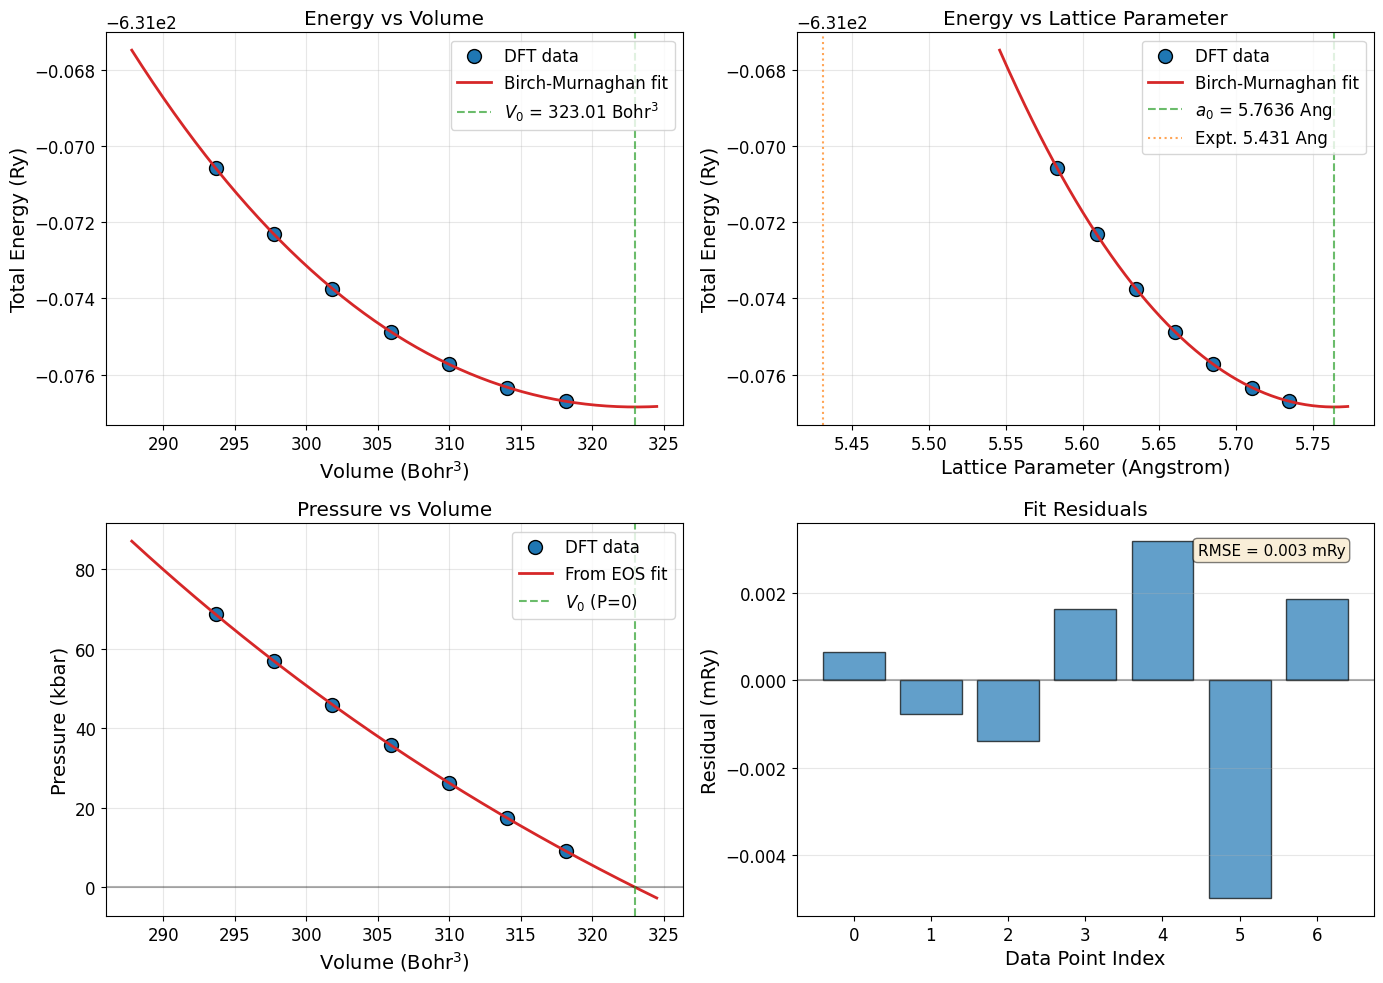

In [23]:
# Create publication-quality plots
import matplotlib.pyplot as plt

fig = plot_eos(V_data, E_data, fit_results, pressures=P_data,
               save_path=WORK_DIR / f'{MATERIAL}_eos_bm_fit.png')
plt.show()

---

## 9. Practical Workflow for Structure Optimization

### Recommended Workflow

```
Step 1: Convergence Tests (at initial structure)
        |-- ecutwfc convergence
        |-- k-point convergence
        v
Step 2: Volume Optimization
        |-- Option A: EOS fitting (recommended)
        |-- Option B: vc-relax with cell_dofree='ibrav'
        v
Step 3: Ionic Relaxation (at optimal volume)
        |-- relax calculation
        v
Step 4: Verification
        |-- Check forces ~ 0
        |-- Check pressure ~ 0
        v
Step 5: Production Calculations
```

### When to Use Each Method

| Situation | Recommended Approach |
|-----------|---------------------|
| Simple materials (Si, metals) | EOS fitting |
| Complex structures | vc-relax first, then verify with EOS |
| Need bulk modulus | EOS fitting (mandatory) |
| High-pressure studies | EOS + vc-relax at target pressure |
| Unknown structure | vc-relax with cell_dofree='all' |
| Fixed cell, optimize atoms | relax only |

---

## 10. Extracting and Saving Optimized Structure

In [24]:
def extract_optimized_structure(output_text):
    """
    Extract final atomic positions and cell parameters from relaxation output.
    
    Parameters
    ----------
    output_text : str
        Content of QE output file from relax or vc-relax calculation
    
    Returns
    -------
    dict
        Dictionary containing:
        - 'cell_parameters': 3x3 array of cell vectors (if found)
        - 'atomic_positions': list of (symbol, x, y, z) tuples
        - 'position_units': 'crystal', 'angstrom', etc.
        - 'alat': lattice parameter if ibrav != 0
    """
    lines = output_text.split('\n')
    results = {}
    
    # Find FINAL coordinates (last occurrence of ATOMIC_POSITIONS)
    positions = []
    in_positions = False
    position_units = None
    
    # Find final cell parameters
    cell_vectors = []
    in_cell = False
    
    # We want the LAST occurrence (final structure), so we scan the whole file
    for i, line in enumerate(lines):
        # Parse CELL_PARAMETERS
        if 'CELL_PARAMETERS' in line:
            in_cell = True
            cell_vectors = []
            continue
        
        if in_cell:
            parts = line.split()
            if len(parts) == 3:
                cell_vectors.append([float(x) for x in parts])
                if len(cell_vectors) == 3:
                    in_cell = False
            elif len(parts) != 0:
                in_cell = False
        
        # Parse ATOMIC_POSITIONS
        if 'ATOMIC_POSITIONS' in line:
            in_positions = True
            positions = []
            # Extract units
            if 'crystal' in line.lower():
                position_units = 'crystal'
            elif 'angstrom' in line.lower():
                position_units = 'angstrom'
            elif 'bohr' in line.lower():
                position_units = 'bohr'
            else:
                position_units = 'alat'
            continue
        
        if in_positions:
            parts = line.split()
            if len(parts) >= 4:
                symbol = parts[0]
                x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                positions.append((symbol, x, y, z))
            elif len(parts) == 0 or 'End' in line:
                in_positions = False
        
        # Parse final alat (for ibrav != 0 cases)
        if 'lattice parameter (alat)' in line:
            match = re.search(r'=\s+([\d.]+)', line)
            if match:
                results['alat'] = float(match.group(1))
    
    if cell_vectors:
        results['cell_parameters'] = np.array(cell_vectors)
    
    if positions:
        results['atomic_positions'] = positions
        results['position_units'] = position_units
    
    return results

In [25]:
def write_optimized_input(structure, ecutwfc, ecutrho, kpoints, pseudo_dir,
                          prefix='optimized', calculation='scf'):
    """
    Write a new QE input file using optimized structure.
    
    Parameters
    ----------
    structure : dict
        Output from extract_optimized_structure()
    ecutwfc, ecutrho : float
        Cutoff energies
    kpoints : tuple
        K-point grid
    pseudo_dir : str or Path
        Pseudopotential directory
    prefix : str
        Job prefix
    calculation : str
        Calculation type
    
    Returns
    -------
    str
        Complete input file content
    """
    kx, ky, kz = kpoints
    positions = structure.get('atomic_positions', [])
    units = structure.get('position_units', 'crystal')
    nat = len(positions)
    
    # Get unique species
    species = list(set([p[0] for p in positions]))
    ntyp = len(species)
    
    # Build input
    input_lines = []
    
    input_lines.append(f"""&CONTROL
    calculation = '{calculation}'
    prefix = '{prefix}'
    outdir = './tmp'
    pseudo_dir = '{pseudo_dir}'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/""")
    
    # System namelist
    if 'cell_parameters' in structure:
        # Use ibrav=0 with explicit cell
        input_lines.append(f"""\n&SYSTEM
    ibrav = 0
    nat = {nat}
    ntyp = {ntyp}
    ecutwfc = {ecutwfc}
    ecutrho = {ecutrho}
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.01
/""")
    else:
        # Use ibrav=2 (FCC) with celldm(1)
        alat = structure.get('alat', 10.26)
        input_lines.append(f"""\n&SYSTEM
    ibrav = 2
    celldm(1) = {alat}
    nat = {nat}
    ntyp = {ntyp}
    ecutwfc = {ecutwfc}
    ecutrho = {ecutrho}
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.01
/""")
    
    input_lines.append("""\n&ELECTRONS
    conv_thr = 1.0e-8
    mixing_beta = 0.7
/""")
    
    # Cell parameters card (if ibrav=0)
    if 'cell_parameters' in structure:
        cell = structure['cell_parameters']
        input_lines.append("\nCELL_PARAMETERS {angstrom}")
        for row in cell:
            input_lines.append(f"  {row[0]:16.10f}  {row[1]:16.10f}  {row[2]:16.10f}")
    
    # Atomic species
    input_lines.append("\nATOMIC_SPECIES")
    # Simple mapping for common elements
    masses = {'Si': 28.0855, 'C': 12.011, 'O': 15.999, 'N': 14.007, 'H': 1.008}
    for sp in species:
        mass = masses.get(sp, 1.0)
        input_lines.append(f"    {sp}  {mass}  {sp}.upf")
    
    # Atomic positions
    input_lines.append(f"\nATOMIC_POSITIONS {{{units}}}")
    for symbol, x, y, z in positions:
        input_lines.append(f"    {symbol}  {x:14.10f}  {y:14.10f}  {z:14.10f}")
    
    # K-points
    input_lines.append(f"\nK_POINTS {{automatic}}")
    input_lines.append(f"    {kx} {ky} {kz} 0 0 0")
    
    return '\n'.join(input_lines)

In [26]:
def write_cif(structure, alat_angstrom, filename):
    """
    Write structure to CIF format for use in other codes.
    
    Parameters
    ----------
    structure : dict
        Structure dictionary with atomic positions
    alat_angstrom : float
        Lattice parameter in Angstrom (for cubic systems)
    filename : str or Path
        Output CIF file path
    """
    positions = structure.get('atomic_positions', [])
    
    cif_lines = [
        "data_optimized_structure",
        "_symmetry_space_group_name_H-M   'F d -3 m'",
        "_symmetry_Int_Tables_number      227",
        f"_cell_length_a                   {alat_angstrom:.6f}",
        f"_cell_length_b                   {alat_angstrom:.6f}",
        f"_cell_length_c                   {alat_angstrom:.6f}",
        "_cell_angle_alpha                90.000000",
        "_cell_angle_beta                 90.000000",
        "_cell_angle_gamma                90.000000",
        "",
        "loop_",
        "_atom_site_label",
        "_atom_site_type_symbol",
        "_atom_site_fract_x",
        "_atom_site_fract_y",
        "_atom_site_fract_z",
    ]
    
    for i, (symbol, x, y, z) in enumerate(positions):
        label = f"{symbol}{i+1}"
        cif_lines.append(f"{label}  {symbol}  {x:.6f}  {y:.6f}  {z:.6f}")
    
    with open(filename, 'w') as f:
        f.write('\n'.join(cif_lines))
    
    print(f"CIF file written to: {filename}")

In [27]:
# Demonstrate saving optimized structure (based on EOS fit)
print("Saving Optimized Structure")
print("=" * 60)

from ase.io import write

# Build optimized structure from fitted lattice parameter
atoms_opt = bulk(MATERIAL, 'diamond', a=fit_results['a0_angstrom'])
opt_elements = list(set(atoms_opt.get_chemical_symbols()))
setup_pseudopotentials(opt_elements, functional=FUNCTIONAL)

opt_pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in opt_elements}

opt_prefix = f'{MATERIAL.lower()}_optimized'
opt_input_file = WORK_DIR / f'{opt_prefix}.in'

opt_input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': opt_prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
        'tprnfor': True,
        'tstress': True,
        'verbosity': 'high',
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {
        'conv_thr': 1.0e-8,
    },
}

write_espresso_in(opt_input_file, atoms_opt, input_data=opt_input_data,
                  pseudopotentials=opt_pseudopotentials, kpts=(kgrid, kgrid, kgrid))

# Write CIF of optimized structure
cif_file = WORK_DIR / f'{MATERIAL}_optimized.cif'
write(str(cif_file), atoms_opt)

print(f"Optimized lattice parameter: a0 = {fit_results['a0_angstrom']:.4f} Å")
print(f"QE input written to: {opt_input_file}")
print(f"CIF written to: {cif_file}")

print("\nOptimized QE input (first 80 lines):")
print("-" * 60)
print('\n'.join(opt_input_file.read_text().splitlines()[:80]))

Saving Optimized Structure
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Ge: Ge.pbe-dn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
Optimized lattice parameter: a0 = 5.7636 Å
QE input written to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_eos_Ge_20260204_193709/ge_optimized.in
CIF written to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/05_eos_Ge_20260204_193709/Ge_optimized.cif

Optimized QE input (first 80 lines):
------------------------------------------------------------
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = './tmp'
   prefix           = 'ge_optimized'
   pseudo_dir       = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
/
&SYSTEM
   ecutwfc          = 45
   ecutrho          = 520.0
   occupations      = 'smearing'
   degauss          = 0.01
   smearing         = 'c

---

## 11. Save Optimized Parameters

In [28]:
# Update the converged parameters file
params_file = WORKSHOP_ROOT / 'converged_parameters.json'

if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
else:
    params = {}

# Add structure optimization results
params['celldm1_optimized_bohr'] = float(fit_results['a0_bohr'])
params['a_optimized_angstrom'] = float(fit_results['a0_angstrom'])
params['V0_bohr3'] = float(fit_results['V0'])
params['E0_ry'] = float(fit_results['E0'])
params['bulk_modulus_gpa'] = float(fit_results['B0_gpa'])
params['bulk_modulus_derivative'] = float(fit_results['B0_prime'])

with open(params_file, 'w') as f:
    json.dump(params, f, indent=2)

print("Updated converged parameters:")
print(json.dumps(params, indent=2))
print(f"\nSaved to: {params_file}")

Updated converged parameters:
{
  "material": "Ge",
  "functional": "PBE",
  "convergence_criteria": {
    "energy_mev_per_atom": 1.0
  },
  "ecutwfc": {
    "converged": 60.0,
    "recommended": 65.0,
    "unit": "Ry"
  },
  "ecutrho": {
    "factor": 8,
    "recommended": 520.0,
    "unit": "Ry"
  },
  "kpoints": {
    "converged": 10,
    "recommended": 12,
    "grid": [
      12,
      12,
      12
    ]
  },
  "metadata": {
    "date": "2026-02-04",
    "notebook": "04_Convergence_Testing.ipynb"
  },
  "celldm1_optimized_bohr": 10.89159657799399,
  "a_optimized_angstrom": 5.7635824023531255,
  "V0_bohr3": 323.00901922331644,
  "E0_ry": -631.0768517120702,
  "bulk_modulus_gpa": 58.15184611022393,
  "bulk_modulus_derivative": 4.479672429508525
}

Saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/converged_parameters.json


---

## Summary

In this notebook, we have covered:

### 1. Why Structure Optimization is Essential
- Database structures are not at DFT equilibrium
- Different functionals give different equilibrium structures
- Must optimize with YOUR methodology before property calculations

### 2. Types of Optimization in Quantum ESPRESSO
- `calculation = 'relax'`: Ionic positions only (fixed cell)
- `calculation = 'vc-relax'`: Variable cell (ions + cell shape + volume)

### 3. Equation of State Method
- More robust than vc-relax for volume optimization
- Provides bulk modulus and its pressure derivative
- Birch-Murnaghan equation: $E(V) = E_0 + \frac{9V_0B_0}{16}[(\eta-1)^3 B_0' + (\eta-1)^2(6-4\eta)]$

### 4. Key Results for Silicon (PBE)

| Property | DFT (PBE) | Experiment | Typical Error |
|----------|-----------|------------|---------------|
| Lattice parameter | ~5.47 Ang | 5.431 Ang | +1-2% |
| Bulk modulus | ~93 GPa | 98.8 GPa | -5-10% |

### 5. Practical Workflow
1. Convergence tests at initial structure
2. Volume optimization (EOS or vc-relax)
3. Ionic relaxation at optimal volume
4. Verify forces ~ 0, pressure ~ 0

### Next Steps
With the optimized structure, you can proceed to:
- **Band Structure Calculations** (Notebook 06)
- **Density of States** (Notebook 07)
- **Phonon Calculations**
- **Optical Properties**